# Redes convolucionales en PyTorch

Bibliografía:
- Machine Learning with PyTorch and Scikit-Learn: Develop machine learning and deep learning models with Python (capítulo 14), Sebastian Rachska et al., 2022 Packt
- Deep Learning with PyTorch, Eli Stevens et al, 2020 Manning
- Deep Learning with Python (capítulo 2), Francois Chollet, 2018 Manning
- https://pytorch.org/tutorials

En este noteboook presentamos:
- Uso de datasets incluidos internamente en TensorFlow (FashionMNIST y MNIST)
- Construcción de modelos de clasificación de imágenes utilizando neuronas ```Conv2d```, ```MaxPool2d```, ```Linear``` y ```Flatten```.
- Tratamiento de imágenes en escala de grises con modelos convolucionales 2D.
- Persistencia de modelos

Utilizamos los siguientes componentes técnicos:
- layers: ```Conv2d```, ```MaxPooling2d```, ```Flatten```, ```Linear```
- optimizadores: ```Adam```
- loss functions: ```CrossEntropyLoss```
- métricas de seguimiento y evaluación: accuracy
- funciones de activación: relu, softmax
- métodos de persistencia de modelos

Vamos a crear un modelo de clasificación de imágenes para los datasets FashionMNIST y MNIST que utilice capas con filtros (kernels) convolucionales.


La diferencia entre un modelo convolucional y uno "fully connected" es que este último aprende patrones globales, mientras que el convolucional aprende patrones locales, lo cual es muy importante en el caso del análisis de imágenes, presentando 2 características muy importantes:
- los patrones aprendidos son invariantes a la traslación: una capa convolucional puede reconocer el patrón independientemente de dónde se encuentre en la imagen, uno fully connected necesitaría una red dependiente del lugar donde esté el mismo patrón en dos imágenes diferentes.
- se puede reconocer una jerarquía espacial entre los patrones aprendidos: las primeras capas convolucionales aprenden a un mayor nivel de abstracción, que se va especializando a medida que las capas son más profundas. Las abstracciones de las primeras capas son los bloques que componen los patrones de las siguientes capas, todo sucesivamente, hasta llegar a la última capa con mayor complejidad en las representaciones que puede aprender.

## Preparación del dataset Fashion MNIST

In [1]:
#import pandas as pd
import os # gestion de archivos y directorios
import os.path as osp # gestion de paths de archivos y directorios
import time

import numpy as np
import random
import matplotlib.pyplot as plt
import torch, torchvision
import torch.nn.functional as F
from torch import nn

In [2]:
#!pip install torchmetrics
import torchmetrics # métricas de modelos

In [3]:
torch.__version__

'1.12.0+cpu'

Si hay una GPU disponible, la utilizaremos.

In [4]:
!nvidia-smi

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
if torch.cuda.is_available():
    print("Utilizamos la primera GPU disponible")
    DEVICE=device = torch.device('cuda:0')
else:
    print("No hay GPU, toca correr todo en CPU")
    DEVICE=device = torch.device('cpu')

DEVICE

No hay GPU, toca correr todo en CPU


device(type='cpu')

Las GPUs y CPUs tienen diferentes semillas de generación aleatoria que no están sincronizadas. Además, algunas operaciones en GPUs se implementan por defecto estocásticamente para que sean más eficientes.
Por todo esto, para garantizar reproducibilidad, necesitamos configurar las semillas por aparte, e indicar el deseo de un proceso determinístico en caso de usar GPUs.

In [6]:
def reset_seed():
    random_seed = 42
    torch.backends.cudnn.enabled = True
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    random.seed(random_seed)

    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(42)
        torch.cuda.manual_seed_all(42)

        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

reset_seed()

Cargamos **Fashion MNIST** del paquete **torchvision**. Al igual que con el dataset **MNIST**, se trata de un dataset de imágenes en escala de grises, clasificadas en 10 categorías (tipos de prendas). Para saber mas acerca del dataset, ir a https://github.com/zalandoresearch/fashion-mnist.

Vamos a seguir el mismo proceso que con el dataset de **MNIST**, lo vamos a descargar en memoria (y en disco) en una instancia de ```torch.utils.data.Dataset```, que luego será manipulado a partir de una instancia de ```torch.utils.data.DataLoader```.

In [7]:
# Verificamos que exista el directorio de data, sino, lo creamos
if not os.path.exists("../data"):
    os.mkdir("../data")

In [8]:
# Definimos una transformación que convierte los datos en tensores de Pytorch al descargarlos
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

# Download and load the training data
fashion_train_dataset = torchvision.datasets.FashionMNIST('../data/', download = True, train = True, transform = transform)
fashion_test_dataset = torchvision.datasets.FashionMNIST('../data/', download = True, train = False, transform = transform)
train_loader = torch.utils.data.DataLoader(fashion_train_dataset, batch_size = 256, shuffle = True)
test_loader = torch.utils.data.DataLoader(fashion_test_dataset, batch_size = 1024, shuffle = True)

In [9]:
fashion_train_dataset.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Veámos algunas de las imágenes:

Feature batch shape: torch.Size([256, 1, 28, 28])
Labels batch shape: torch.Size([256])


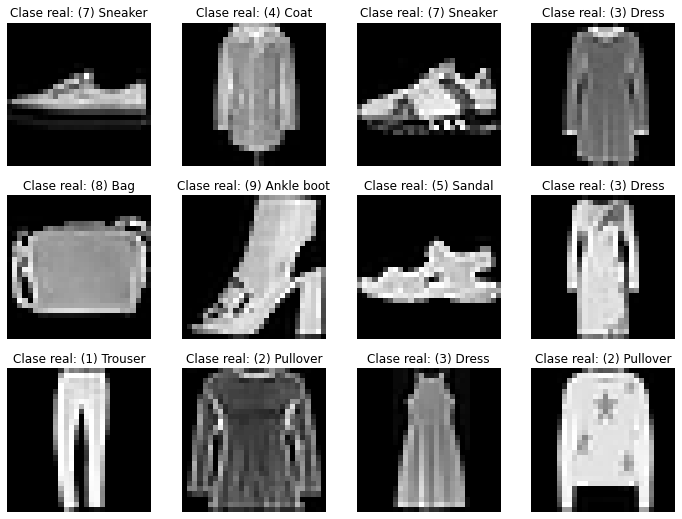

In [11]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

figure = plt.figure(figsize=(12, 9))

cols, rows = 4, 3
for i in range(1, cols * rows + 1):    
    img = train_features[i]
    label = fashion_train_dataset.classes[train_labels[i]]
    figure.add_subplot(rows, cols, i)
    plt.title(f"Clase real: ({train_labels[i]}) {label}")
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

El primer eje corresponde al batch, el segundo al canal de color (uno solo - gris), y el tercero y cuarto al alto y ancho de la imágen.
Veamos los valores de una de las filas de la primera imágen.

In [12]:
train_features[0][0][10]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.3725, 0.7451, 0.2000, 0.6588, 0.5647, 1.0000,
        0.1686, 0.1098, 0.4118, 0.3529, 0.2941, 0.6706, 0.5725, 0.2078, 0.2941,
        0.0000])

Los datos ya están normalizados de tal manera que el negro corresponde a un valor de 0 y el blanco a un valor de 1.

## Construcción de una red convolucional con PyTorch

### Convoluciones

Las convoluciones en imágenes operan sobre tensores de rango 3 llamados **feature maps**, con dos ejes espaciales (alto y ancho) y uno de profundidad (los canales). Las imágenes del FashionMNIST solo tenían los ejes espaciales, es por esto que se agregó el tercer eje con un solo canal (nivel de gris).
Los filtros de las convoluciones van aplicándose a ventanas de las imágenes de entrada, produciendo **feature maps** de salida, donde la profundidad (el eje de canales) está dada por el número de filtros en cada capa. Cada filtro produce la imágen de un canal. 

Esto también aplica para imágenes de entrada con múltiples canales: si fueran RGB, cada filtro produce al final un feature map de un solo canal. Cada filtro se aplicaría a los diferentes canales de entrada. En la primera capa convolucional se reciben entonces imágenes de 28x28x3, se consideran entonces ventanas de 26x26 (dado el padding 'valid', ver en la subsección siguiente), por cada uno de los canales RGB. Así, un filtro aplicado va a producir 3 imágenes de 26x26 que se deben agregar en una sola; el promedio de las 3 imágenes creadas por un filtro va a dar la imagen 26x26 del canal de salida correspondiente al filtro en cuestión.

En Keras, una capa convolucional se especifica con 2 parámetros principales: la profundidad (número de filtros), y el tamaño del filtro (alto, ancho) que se va a desplazar a cada ventana de los inputs 2D.

### Padding, strides y número de parámetros

Las capas convolucionales y de pooling tienen como argumento el tipo de **padding** a utilizar, que consiste en la configuración a seguir cuando se estén tratando los pixeles que se encuentren en los extremos de las imágenes. Existen 2 tipos (no incluimos el padding **full**):
* '**valid**': que no agrega pixeles en los extremos de las imágenes, teniendo como resultado imágenes de salida con un tamaño inferior al de la entrada. El qué tan inferior depende del tamaño del filtro. Con un padding 'valid' y con filtros 3x3, se reduce en 2 pixeles el alto y ancho de las imágenes; con filtros 5x5, se reducen en 4 pixeles; con filtros 7x7 se reducen en 6 pixeles. Este es el valor por defecto en las capas convolucionales y de pooling.
* '**same**': que agrega los pixeles que sean necesarios en los extremos de las imágenes para que las imágenes de salida tengan el mismo alto y ancho que las de entrada.

En cuanto al **stride** a utilizar, que especifica los saltos que se deben tomar en cada ventana de análisis:
* en el caso de las convoluciones, el stride por defecto es de (1, 1), es decir, los filtros se aplican en ventanas que se mueven de a 1 pixel en el eje del alto y de a 1 pixel en el eje del ancho.
* en el caso del pooling, el stride por defecto es igual al tamaño de la ventana (*pool_size*), de tal manera que las ventanas de análisis no se sobreponen nunca.

Las capas ```torch.nn.Conv2d```, reciben los siguientes parámetros durante su creación (los más importantes):
- ```in_channels```: el número de canales del tensor de entrada de la capa. En el caso de la capa inicial que recibe imágenes RGB su valor sería de 3, en el caso de capas posteriores, recibe el número de feature maps producidos por la capa anterior (e.g. número de filtros convolucionales si la capa anterior es una capa convolucional).
- ```out_channels```: el número de canales del tensor de salida producidos por esta capa, es decir, el número de filtros convolucionales de esta capa.
- ```kernel_size```: el tamaño de la ventana del kernel de los filtros convolucionales de esta capa. Si se especifica un escalar (valores comunes son 1, 3, 5), el filtro tendrá el mismo tamaño en todos los ejes. Se puede especificar una tupla con diferentes tamaños en los diferentes ejes.
- ```stride```: el tamaño del salto al hacer la operación de convolución. Si se especifica un solo número, se supone el mismo salto en todos los ejes. Puede especificarse una tupla para saltos diferentes a lo largo de cada eje. Su valor es 1, por defecto
- ```padding```: el tipo de padding a utilizar, por defecto es "valid", pero se puede establecer "same" si se desea. También se puede definir con una tupla un padding diferente.
- ```device```: determina el dispositivo que alojará el tensor de los parámetros (CPU o CUDA).

Los únicos parámetros obligatorios son el número de canales de entrada, de salida, y el tamaño del filtro.

Creemos una capa convolucional con 16 filtros y analicemos sus parámetros y el efecto de aplicarla sobre un batch de imágenes.

In [13]:
conv_layer = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3)
for i in conv_layer.named_parameters():
    print(f"parámetro {i[0]}: {i[1].shape}")

parámetro weight: torch.Size([16, 1, 3, 3])
parámetro bias: torch.Size([16])


El número de parámetros de cada filtro es de (KxKxin_channels\ + 1 sesgo) = (3x3x1 + 1) = 10. Cómo tenemos 16 filtros, tendremos 160 parámetros en esta capa convolucional.

In [14]:
output_conv = conv_layer(train_features)
print(f"Tensor de entrada a la capa convolucional: {train_features.shape}")
print(f"Tensor resultado de la capa convolucional: {output_conv.shape}")

Tensor de entrada a la capa convolucional: torch.Size([256, 1, 28, 28])
Tensor resultado de la capa convolucional: torch.Size([256, 16, 26, 26])


Podemos ver que el tensor resultado del paso de la capa convolucional tiene:
- un primer eje representando el tamaño del batch, que no se modifica, cada instancia de entrada tiene su instancia de salida correspondiente
- un segundo eje en donde vemos que se tienen 16 feature maps producidos por la capa, ya que se definieron 16 filtros convolucionales. Cada kernel gerena su propio feature map, que se concatenan en el tensor de salida
- un tercer y cuarto eje en los que se redujo el tamaño del feature map en 2 pixeles (un pixel arriba y uno a la derecha en el eje del alto, uno a la derecha y otro a la izquierda en el eje del ancho), pues se tiene un kernel de tamaño 3, con stride 1 (valor por defecto) y con padding "valid" (por defecto).

### Pooling

Las capas convolucionales son a menudo seguidas de capas de **pooling** que permiten reducir la dimensionalidad (y el número de parámetros de los pesos de capas convolucionales subsecuentes. Las capas de pooling consisten en ventanas que se deslizan sobre las imágenes de entrada para resumir los datos. La función de agregación más usada es el **max**, pero tambien es posible usar poolings con **average**.

Por defecto, las ventanas tienen un stride correspondiente al tamaño de las mismas, de tal modo que se divide el tamaño de las imágenes de entrada por el tamaño de la ventana del pooling para dar una representación de salida con dimensiones reducidas. Con ventanas de 2x2 (las mas usuales), el pooling termina reduciendo las imágenes a la mitad.

Las capas de pooling, y la reducción de las imágenes son necesarias porque, por un lado, esto permite que las capas mas profundas tengan una visión mayor, cada vez menos localizada de las capas superiores, uno de los objetivos es aprender la jerarquía espacial de los patrones detectados; las convoluciones sucesivas tienen una visión cada vez más grande de los datos.
Por otro lado, el número de valores de la última capa convolucional debe reducirse, teniendo en cuenta la conexión con las capas densas finales, y no tener millones de parámetros y los problemas que ello genera (tiempo y espacio durante el entrenamiento, overfitting).

La reducción de los datos también se pudo haber logrado utilizando strides, o utilizar un promedio de los datos agregados, pero en la aplicación, max pooling tiende a funcionar mejor.

Las capas ```torch.nn.MaxPool2d```, reciben los siguientes parámetros durante su creación (los más importantes):
- ```kernel_size```: el tamaño de la ventana de agregación. Si se especifica un escalar, el filtro tendrá el mismo tamaño en todos los ejes. Se puede especificar una tupla con diferentes tamaños en los diferentes ejes.
- ```stride```: el tamaño del salto al hacer la operación de agregación. Si se especifica un solo número, se supone el mismo salto en todos los ejes. Puede especificarse una tupla para saltos diferentes a lo largo de cada eje. Por defecto se toman las mismas dimensiones que para el ```kernel_size```.
- ```padding```: el número de ceros a agregar en cada borde, por defecto su valor es 0.

Se debe definir al menos el ```kernel_size```.

Creemos una capa convolucional y analicemos sus parámetros y el efecto de aplicarla sobre un batch de imágenes.

In [15]:
pool_layer = nn.MaxPool2d(kernel_size=2)
for i in pool_layer.named_parameters():
    print(f"parámetro {i[0]}: {i[1].shape}")

In [16]:
output_pool = pool_layer(output_conv)
print(f"Tensor de entrada a la capa de pooling: {output_conv.shape}")
print(f"Tensor resultado de la capa de pooling: {output_pool.shape}")

Tensor de entrada a la capa de pooling: torch.Size([256, 16, 26, 26])
Tensor resultado de la capa de pooling: torch.Size([256, 16, 13, 13])


Podemos ver que el tensor resultado del paso de la capa de pooling tiene:
- un primer eje representando el tamaño del batch, que no se modifica, cada instancia de entrada tiene su instancia de salida correspondiente
- un segundo eje en donde vemos que se conservan los canales de entrada
- un tercer y cuarto eje en los que se redujo el tamaño del feature map en 2, dado el tamaño de la ventana.

### Modelo secuencial convolucional

Cuando se desesa construir un modelo cuyas capas se conectan una detrás de otra, se puede simplificar el proceso utilizando ```nn.Sequential```, un módulo contenedor de módulos ordenados secuencialmente, encadenando el procesamiento a través de los llamados a los métodos ```forward()``` de cada uno de los módulos. Las funciones de activación se agregarán como módulos miembro.
El modelo que crearemos tendrá:
- una capa ```Conv2d``` con 16 filtros de tamaño 3x3. Tiene como entrada tensores de dimensionalidad (28, 28, 1), produciendo features maps de (16, 26, 26)
Por cada filtro aplicado, se tiene un feature map de salida resultado de la convolución; si hay N filtros, el tensor de salida tendrá una profundidad de N.
Esta capa tiene entonces 16x(3x3x1 + 1)=160 parámetros.
- una capa ```MaxPool2d```con una ventana de tamaño 3x3, que reducirá el tamaño de los feature maps a (16, 8, 8), ya que solo se conserva la parte entera de la división 26/3, ignorando lo últimos 2 pixeles a la derecha y abajo de la imagen. Las capas de pooling no requieren parámetros. 
Esta capa permite:
  - si la capa siguiente es una capa convolucional: reducir el número de operaciones a realizar
  - si la capa siguiente es una capa densa (no contando una ```Flatten```): reducir el número de conexiones necesarias y por ende de parámetros de pesos, al comprimir la imagen, en este caso, a 1/9 de su tamaño original.
- una capa ```Flatten``` que se encarga de aplanar los feature maps para que queden en un solo array de 16x8x8=1024 entradas de la capa densa siguiente. Las capas ```Flatten``` no requieren parámetros.
- una capa densa ```Linear``` de 10 neuronas que produce los logits que permitirán la clasificación final, con una neurona por cada categoría posible, que necesita el ajuste de 10x1024+10=10250 parámetros.

Vamos a crear una clase de Python que represente el modelo convolucional basándose en los modulos que serán organizados por el contenedor ```nn.Sequential``` (que también hereda de ```torch.nn.Module```). Implementaremos los dos métodos siguientes:
- un método constructor ```__init__()```, en donde se declaran las capas y demás módulos con parámetros. Este método recibe el número de canales del tensor de entrada y el número de categorias de la última capa.
- un método ```forward()```, que se encarga de establecer las operaciones del feed forward, que es trackeado indirectamente por PyTorch para la propagación de gradientes.

In [17]:
class ClassifConv1Layers(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(ClassifConv1Layers, self).__init__()    

        self.conv = nn.Sequential(         
            nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=3, stride=1, padding="valid"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3),
            nn.Flatten(),
            nn.Linear(in_features=16*8*8, out_features=num_classes)
        )

    def forward(self, image):
        logits = self.conv(image)
        return logits

In [18]:
modelo_fashion = ClassifConv1Layers(in_channels=1, num_classes=10)
modelo_fashion

ClassifConv1Layers(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=1024, out_features=10, bias=True)
  )
)

Veamos los parámetros del modelo:

In [19]:
for param in modelo_fashion.parameters():
    print(f"{param.shape}")

torch.Size([16, 1, 3, 3])
torch.Size([16])
torch.Size([10, 1024])
torch.Size([10])


Ahora, apliquemos el modelo recién creado a un batch de imágenes.

In [20]:
modelo_fashion.eval()
preds = modelo_fashion(train_features)
print(preds.shape)
preds[0]

torch.Size([256, 10])


tensor([ 0.0138,  0.1380,  0.0986, -0.0088,  0.2029,  0.1016,  0.0442,  0.0789,
         0.1071, -0.1587], grad_fn=<SelectBackward0>)

Vemos que el batch de predicciones tiene el mismo tamaño que el batch de imágenes (una predicción por cada imagen).
Cada una de las predicciones es un array con 10 valores (los logits).

## Entrenamiento del modelo

Durante el entrenamiento del modelo necesitamos comparar para todo un batch las predicciones con los valores reales utilizaremos ```nn.CrossEntropyLoss()``` como función de pérdida, que recibe los labels numéricos y las predicciones en forma de logits.

Utilizaremos un optimizador **Adam**, instanciando la clase ```torch.optim.Adam```. Al crearlo, le indicaremos los objetivos de optimización (los parámetros del modelo, que se obtienen a partir del método ```parameters()```), así como el learning rate. Se puede especificar otros hiper parámetros más detallados si se desea.

**OJO**: Es una buena práctica llamar al método ```eval()``` del modelo cuando se va a utilizar para inferencia y ```train()``` cuando se esté entrenando. Lo explicaremos en el siguiente modelo cuando veamos modelos con capas **Dropout** y **BatchNormalization**.

Creamos un ciclo de entrenamiento similar al del notebook anterior, aunque esta vez crearemos un dataset de validación a partir del dataset de entrenamiento, teniendo al final un training set, un validation set y un test set.

In [21]:
def train_model(modelo, train_dataset, train_batch_size=128, learning_rate = 1e-3, epocas=30, val_split=0, verbose=False):
    """Se encarga de realizar el ciclo de épocas de entrenamiento.

    :modelo:
        instancia creada del modelo a entrenar
    :train_dataset:
        instancia de Dataset con los datos de entrenamiento
    :train_batch_size:
        tamaño del batch size de entrenamiento
    :learning_rate:
        learning rate del optimizador.
    :epocas:
        número de iteraciones de entrenamiento sobre el dataset completo
    :val_split:
        porcentaje del dataset de entrenamiento dedicado a la validación, su valor será limitado al intervalo [0 (sin validación), 0.5]
    :verbose:
        indica si se quiere imprimr el avance del proceso o no
    :returns:
        el modelo entrenado y 4 arrays con los valores de losses y accuracies del training dataset, y los losses y accuracies del val set después de cada época
    """

    reset_seed()

    # Gestión de los loaders de training y validation
    if val_split > 0.5:
        val_split=0.5

    if val_split < 0:
        val_split=0

    if val_split > 0:
        num_training_instances = int(train_dataset.data.shape[0]*(1-val_split))
        num_validation_instances = int(train_dataset.data.shape[0]*val_split)
        print(f"val_split: {val_split}, num_training_instances {num_training_instances}, num_validation_instances {num_validation_instances}")
        training_subset, validation_subset = torch.utils.data.random_split(
            train_dataset, [num_training_instances, num_validation_instances])
    
        train_loader = torch.utils.data.DataLoader(
            training_subset, batch_size=train_batch_size, shuffle=True, num_workers=2)
        validation_loader = torch.utils.data.DataLoader(
            validation_subset, batch_size=1024, num_workers=2)
        
    else : 
        train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=2)


    # Se crea el modelo y optimizador
    modelo = modelo.to(DEVICE) # situar el modelo en el dispositivo de procesamiento
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(modelo.parameters(), lr=learning_rate)

    # Creamos vectores donde almacenaremos los losses y métricas después de cada época
    train_losses = [0] * epocas
    train_accuracies = [0] * epocas
    val_losses = [0] * epocas
    val_accuracies = [0] * epocas

    for epoca in range(epocas):
        epoca_start_time = time.time()
        modelo.train()
        for batch_features, batch_labels in train_loader:
            # Nos aseguramos que los inputs del modelo estén en el mismo dispositivo
            batch_features = batch_features.to(DEVICE)
            batch_labels = batch_labels.to(DEVICE)
            # Generar las predicciones
            batch_preds = modelo(batch_features)
            # Comparar con las realidades a partir del loss function
            loss = loss_fn(batch_preds, batch_labels)
            # Calcular los gradientes de la función de pérdida
            loss.backward()
            # Actualizar parámetros con los gradientes
            optimizer.step()
            # Resetear los gradientes para no reacumularlos
            optimizer.zero_grad()
            # se acumulan los losses de la epoca (ponderados por el tamaño del batch)
            train_losses[epoca] += loss.item() * batch_labels.size(0)
            # se acumulan las predicciones correctas de la epoca
            correctos = (batch_preds.argmax(1) == batch_labels)
            train_accuracies[epoca] += correctos.type(torch.float).sum().item() 

        # se normalizan el loss y el accuracy del training set
        train_losses[epoca] /= len(train_loader.dataset)
        train_accuracies[epoca] /= len(train_loader.dataset)
        
        if val_split > 0:
            # se desactiva la diferenciación automática para la inferencia sobre el val set
            modelo.eval()
            with torch.no_grad():
                for batch_features, batch_labels in validation_loader:
                    # Nos aseguramos que los inputs del modelo estén en el mismo dispositivo
                    batch_features = batch_features.to(DEVICE)
                    batch_labels = batch_labels.to(DEVICE)
                    # Generar las predicciones
                    batch_preds = modelo(batch_features)
                    # Comparar con las realidades a partir del loss function
                    loss = loss_fn(batch_preds, batch_labels)
                    # se acumulan los losses de la epoca (ponderados por el tamaño del batch)
                    val_losses[epoca] += loss.item() * batch_labels.size(0)
                    # se acumulan las predicciones correctas de la epoca
                    correctos = (batch_preds.argmax(1) == batch_labels)
                    val_accuracies[epoca] += correctos.type(torch.float).sum().item() 
            # se normalizan el loss y el accuracy del val set
            val_losses[epoca] /= len(validation_loader.dataset)
            val_accuracies[epoca] /= len(validation_loader.dataset)

        epoca_end_time = time.time()
        segundos = epoca_end_time - epoca_start_time

        if verbose:
            if val_split > 0:
                print(f"{epoca}:  loss: {train_losses[epoca]:>7f}, accuracy: {train_accuracies[epoca]:>7f}, val loss: {val_losses[epoca]:>7f}, val accuracy: {val_accuracies[epoca]:>7f}",
                      f"-- epoch time: {segundos:.2f}")
            else:
                print(f"{epoca}:  loss: {train_losses[epoca]:>7f}, accuracy: {train_accuracies[epoca]:>7f}",
                      f"-- epoch time: {segundos:.2f}")
    if val_split > 0:     
        return modelo, train_losses, train_accuracies, val_losses, val_accuracies
    else:
        return modelo, train_losses, train_accuracies

Entrenamos el modelo en 50 épocas

In [22]:
modelo_fashion, train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    ClassifConv1Layers(in_channels=1, num_classes=10), fashion_train_dataset,
    train_batch_size=512, learning_rate=1e-3, epocas=50, val_split=0.2, verbose=True)

val_split: 0.2, num_training_instances 48000, num_validation_instances 12000
0:  loss: 1.103273, accuracy: 0.700229, val loss: 0.638283, val accuracy: 0.778667 -- epoch time: 8.79
1:  loss: 0.552251, accuracy: 0.809438, val loss: 0.508196, val accuracy: 0.822167 -- epoch time: 5.59
2:  loss: 0.468903, accuracy: 0.837187, val loss: 0.452532, val accuracy: 0.844000 -- epoch time: 5.64
3:  loss: 0.429524, accuracy: 0.850625, val loss: 0.425718, val accuracy: 0.854000 -- epoch time: 5.56
4:  loss: 0.405783, accuracy: 0.858812, val loss: 0.407094, val accuracy: 0.858250 -- epoch time: 5.61
5:  loss: 0.385101, accuracy: 0.865938, val loss: 0.389931, val accuracy: 0.865083 -- epoch time: 5.61
6:  loss: 0.371903, accuracy: 0.870667, val loss: 0.386201, val accuracy: 0.865583 -- epoch time: 5.64
7:  loss: 0.360766, accuracy: 0.874292, val loss: 0.373961, val accuracy: 0.870083 -- epoch time: 5.66
8:  loss: 0.352373, accuracy: 0.876625, val loss: 0.366004, val accuracy: 0.873667 -- epoch time: 5

Creamos una función reutilizable para plotear los resultados a lo largo del entrenamiento.

In [23]:
def plot_losses_and_accuracies(train_losses, train_accuracies, val_losses=None, val_accuracies=None):
    fig = plt.figure(figsize=(15,6))

    ax = fig.add_subplot(1, 2, 1)
    ax.plot(train_losses)
    if val_losses is not None:
        ax.plot(val_losses)
        plt.legend(['train', 'val'], loc='upper left')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title('model loss')

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(train_accuracies)
    if val_accuracies is not None:
        ax.plot(val_accuracies)
        plt.legend(['train', 'val'], loc='upper left')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.title('model accuracy')

    _=plt.show()


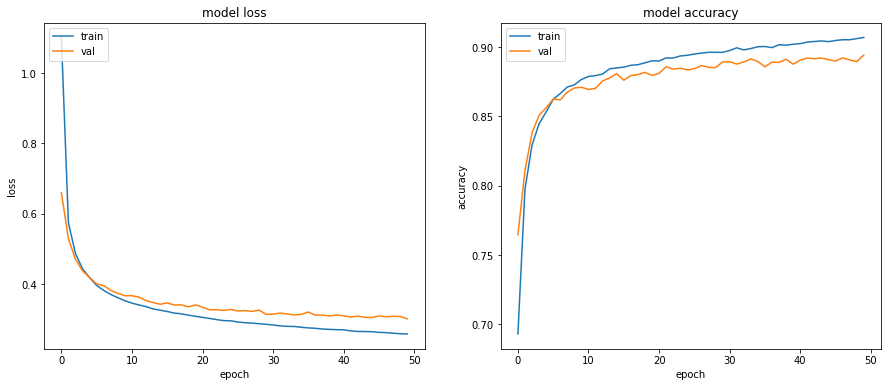

In [ ]:
plot_losses_and_accuracies(train_losses, train_accuracies, val_losses, val_accuracies)

Vemos que en la época 20 empezamos a tener una separación entre las curvas de loss y accuracy entre el training set y validation set. 
Podemos ver que después de alrededor la capa 40, si bien las pérdidas siguen siendo decrecientes, la del validation set desciende a menor velocidad que la del training set, comenzando a tener overfitting

Vamos ahora a evaluar sobre el test set.

In [24]:
def eval_model(modelo, dataloader):
    correctos = 0
    modelo.eval()
    with torch.no_grad():
        for batch_features, batch_labels in dataloader:
            batch_features = batch_features.to(DEVICE)
            batch_labels = batch_labels.to(DEVICE)
            batch_preds = modelo(batch_features)
            correctos += (batch_preds.argmax(1) == batch_labels).type(torch.float).sum().item() 
    return correctos / dataloader.dataset.data.shape[0]

In [25]:
test_acc = eval_model(modelo_fashion, test_loader)

In [26]:
print(f"El mínimo loss de validación {np.min(val_losses):.3f} se alcanzó en la época {np.argmin(val_losses)}")
print(f"El accuracy de entrenamiento correspondiente es de {train_accuracies[np.argmin(val_losses)]:.3f}. ")
print(f"El accuracy de validación correspondiente es de {val_accuracies[np.argmin(val_losses)]:.3f}. ")
print(f"El accuracy de test es de {test_acc:.3f}. ")

El mínimo loss de validación 0.299 se alcanzó en la época 49
El accuracy de entrenamiento correspondiente es de 0.909. 
El accuracy de validación correspondiente es de 0.898. 
El accuracy de test es de 0.891. 


Vemos que el accuracy sobre el test set es de 88.8\%, muy cercano al 89.2\% estimado sobre el validation set y al 90.2\% del training set.

## Proceso completo con modelo convolucional de 2 capas para MNIST y FashionMNIST

Realizamos el proceso completo para el dataset MNIST que contiene imágenes de digitos escritos a mano (10 clases).

Cargamos la data y la ponemos en la forma indicada

In [27]:
# Definimos una transformación que convierte los datos en tensores de Pytorch al descargarlos
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

# Download and load the training data
mnist_train_dataset = torchvision.datasets.MNIST('../data/', download = True, train = True, transform = transform)
mnist_test_dataset = torchvision.datasets.MNIST('../data/', download = True, train = False, transform = transform)
train_loader = torch.utils.data.DataLoader(mnist_train_dataset, batch_size = 256, shuffle = True)
test_loader = torch.utils.data.DataLoader(mnist_test_dataset, batch_size = 1024, shuffle = True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



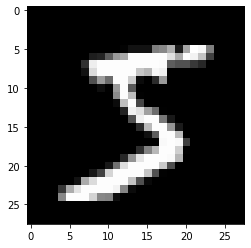

In [28]:
plt.imshow(mnist_train_dataset.data[0], cmap="gray")

In [29]:
class ClassifConv2Layers(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(ClassifConv2Layers, self).__init__()    

        self.conv = nn.Sequential(         
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, stride=1, padding="valid"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding="valid"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(in_features=64*5*5, out_features=num_classes)
        )

    def forward(self, image):
        logits = self.conv(image)
        return logits

Si implementamos la función ```train_model()``` lo más genérica posible, no es necesaria modificarla para otras arquitecturas. Vamos a reutilizarla para entrenar un modelo sobre este otro dataset.

In [30]:
modelo_mnist, train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    ClassifConv2Layers(in_channels=1, num_classes=10), mnist_train_dataset,
    train_batch_size=512, learning_rate=1e-3, epocas=30, val_split=0.2, verbose=True)

val_split: 0.2, num_training_instances 48000, num_validation_instances 12000
0:  loss: 0.587299, accuracy: 0.847063, val loss: 0.199741, val accuracy: 0.942417 -- epoch time: 7.88
1:  loss: 0.139269, accuracy: 0.959792, val loss: 0.119504, val accuracy: 0.963917 -- epoch time: 7.80
2:  loss: 0.094009, accuracy: 0.972063, val loss: 0.087723, val accuracy: 0.973500 -- epoch time: 7.75
3:  loss: 0.071911, accuracy: 0.978167, val loss: 0.075707, val accuracy: 0.977667 -- epoch time: 8.55
4:  loss: 0.061586, accuracy: 0.981375, val loss: 0.065555, val accuracy: 0.980667 -- epoch time: 7.81
5:  loss: 0.052117, accuracy: 0.984271, val loss: 0.063844, val accuracy: 0.980917 -- epoch time: 7.79
6:  loss: 0.047286, accuracy: 0.985563, val loss: 0.055586, val accuracy: 0.983417 -- epoch time: 7.80
7:  loss: 0.042582, accuracy: 0.987604, val loss: 0.055452, val accuracy: 0.983917 -- epoch time: 7.83
8:  loss: 0.039561, accuracy: 0.988542, val loss: 0.050147, val accuracy: 0.984500 -- epoch time: 7

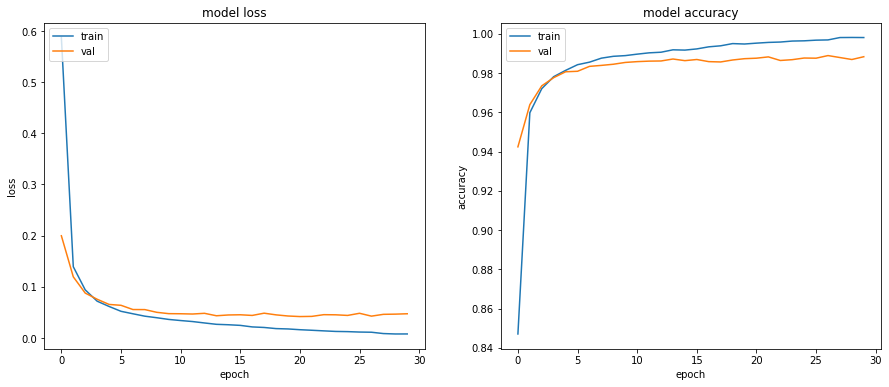

In [31]:
plot_losses_and_accuracies(train_losses, train_accuracies, val_losses, val_accuracies)

In [32]:
test_loader = torch.utils.data.DataLoader(mnist_test_dataset, batch_size = 1024, shuffle = True)

In [33]:
test_acc = eval_model(modelo_mnist, test_loader)

In [34]:
print(f"El mínimo loss de validación {np.min(val_losses):.3f} se alcanzó en la época {np.argmin(val_losses)}")
print(f"El accuracy de entrenamiento correspondiente es de {train_accuracies[np.argmin(val_losses)]:.3f}. ")
print(f"El accuracy de validación correspondiente es de {val_accuracies[np.argmin(val_losses)]:.3f}. ")
print(f"El accuracy de test es de {test_acc:.3f}. ")

El mínimo loss de validación 0.042 se alcanzó en la época 20
El accuracy de entrenamiento correspondiente es de 0.995. 
El accuracy de validación correspondiente es de 0.988. 
El accuracy de test es de 0.989. 


Llegamos a un accuracy de casi el 99\% sobre el test set.

Volvamos a tratar el dataset de **FashionMNIST**, pero esta vez con el modelo de 2 capas convolucionales, y sobre todo el training set (sin validación

In [35]:
modelo_fashion, train_losses, train_accuracies = train_model(
    ClassifConv2Layers(in_channels=1, num_classes=10), fashion_train_dataset,
    train_batch_size=512, learning_rate=1e-3, epocas=30, val_split=0, verbose=True)

0:  loss: 0.845745, accuracy: 0.718267 -- epoch time: 8.26
1:  loss: 0.483006, accuracy: 0.822950 -- epoch time: 8.91
2:  loss: 0.418769, accuracy: 0.850833 -- epoch time: 8.10
3:  loss: 0.388731, accuracy: 0.860650 -- epoch time: 8.15
4:  loss: 0.362047, accuracy: 0.871300 -- epoch time: 8.17
5:  loss: 0.347098, accuracy: 0.875333 -- epoch time: 8.12
6:  loss: 0.333305, accuracy: 0.881183 -- epoch time: 8.24
7:  loss: 0.320669, accuracy: 0.885750 -- epoch time: 8.27
8:  loss: 0.308564, accuracy: 0.889867 -- epoch time: 8.10
9:  loss: 0.301910, accuracy: 0.891233 -- epoch time: 8.15
10:  loss: 0.293338, accuracy: 0.895483 -- epoch time: 8.14
11:  loss: 0.286399, accuracy: 0.897067 -- epoch time: 8.26
12:  loss: 0.281792, accuracy: 0.898667 -- epoch time: 8.74
13:  loss: 0.275322, accuracy: 0.900833 -- epoch time: 8.10
14:  loss: 0.268908, accuracy: 0.902950 -- epoch time: 8.14
15:  loss: 0.263141, accuracy: 0.904917 -- epoch time: 8.15
16:  loss: 0.256859, accuracy: 0.907533 -- epoch t

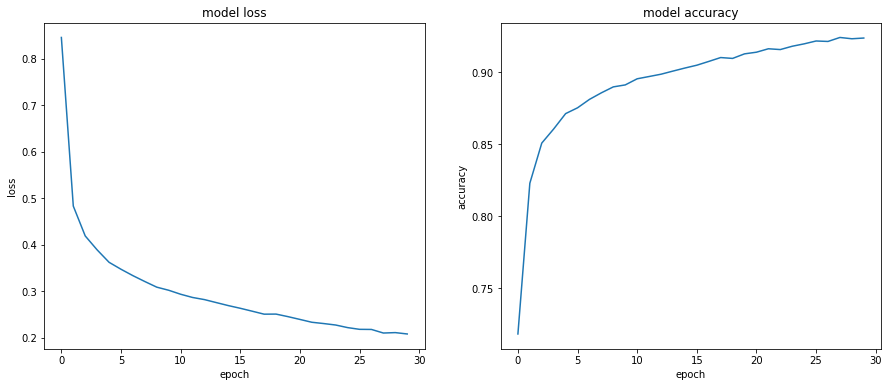

In [36]:
plot_losses_and_accuracies(train_losses, train_accuracies)

In [89]:
test_loader = torch.utils.data.DataLoader(fashion_test_dataset, batch_size = 1024, shuffle = False)

In [90]:
eval_model(modelo_fashion, test_loader)

0.9004

Vemos que llegamos a mas del 90% de accuracy sobre el test set.

## Entendimiento del proceso de activación a partir de convoluciones

En el dataset de test, encontramos que las imágenes que se encuentran en los índices 0, 23, 28 son de botines (label 9).

In [91]:
features, labels = next(iter(test_loader))

In [132]:
FIRST_IMAGE=0
SECOND_IMAGE=28
THIRD_IMAGE=39

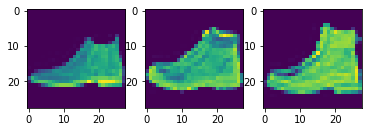

In [133]:
indexes = [FIRST_IMAGE, SECOND_IMAGE, THIRD_IMAGE]
botines = features[indexes]
f, axarr = plt.subplots(1,len(indexes))
for i, img in enumerate(botines):
    axarr[i].imshow(img.squeeze())
    axarr[i].grid(False)
plt.show()

In [134]:
botines = botines.to(DEVICE)

Vamos a analizar las activaciones intermediarias de estas imágenes a través de las capas convolucionales y de MaxPooling.
Veamos como está estructurado el modelo.

In [135]:
modelo_fashion

ClassifConv2Layers(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1600, out_features=10, bias=True)
  )
)

Vemos que el modulo del modelo tiene un submodulo ```Sequential``` llamado "conv", y este tiene internamente los submodulos correspondientes a las capas y funciones de activación, accesibles a partir de su índice en la secuencia.

In [136]:
modelo_fashion.conv[3]

Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)

Si queremos inspeccionar o modificar los resultados o los gradientes de una capa, se utiliza una función llamada **hook**, que se pueden registrar sobre un módulo.
Una función **hook** puede aplicarse al proceso de entrenamiento ya sea sobre la ejecución del forward pass o del backward pass. 
Se pueden registrar funciones **hooks** con los siguientes métodos de la clase ```nn.Module```:
- ```register_forward_hook()```: la función **hook** se llamará después del ```forward()``` del módulo, y recibirá el módulo en cuestión, una tupla con los inputs del forward y el tensor con el output. Se pueden modificar los outputs, así como los inputs de la capa, aunque modificar los inputs no tendrá efecto sobre el resultado del forward. La función **hook** puede retornar ```None``` o el output modificado.
- ```register_forward_pre_hook()```: la función **hook** se llamará antes del ```forward()``` del módulo, y recibirá el módulo en cuestión y una tupla con los inputs del forward. Se pueden modificar los inputs de la capa retornando el nuevo valor en la función **hook**, influyendo en el ```forward()``` siguiente. La función **hook** puede retornar ```None``` o el input modificado.
- ```register_full_backward_hook()```: la función **hook** se llamará cada vez que los gradientes del modulo con respecto a sus inputs sean modificados, y recibirá el módulo en cuestión, una tupla con los gradientes de los inputs y una tupla con los gradientes de los outputs. Modificar los inputs y outputs de generará un error en el método ```backward()```, aunque se puede retornar un valor de gradiente de los inputs diferente. La función **hook** puede retornar ```None``` o un nuevo gradiente del input.

Los métodos de registro de hooks de ```nn.Module``` retornan un "handle" que permitira removerlos hooks, llamando ```handle.remove()```.
**OJO**: no hay manera elegante de eliminar **hooks** a menos de hacerlo a través de los handles retornados.

In [137]:
modelo_fashion.eval()

ClassifConv2Layers(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1600, out_features=10, bias=True)
  )
)

In [138]:
def debug_capa(self, input, output):
    print('Adentro de ' + self.__class__.__name__ + ' forward')
    print('')
    print('input: ', type(input))
    print('   len: ', len(input))
    print('input[0]: ', type(input[0]))
    print('output: ', type(output))
    print('')
    print('input size:', input[0].size())
    print('output size:', output.data.size())
    print('output norm:', output.data.norm())

In [139]:
handle = modelo_fashion.conv[0].register_forward_hook(debug_capa)

In [140]:
with torch.no_grad():
    pred = modelo_fashion(features[FIRST_IMAGE].unsqueeze(0).to(DEVICE))

Adentro de Conv2d forward

input:  <class 'tuple'>
   len:  1
input[0]:  <class 'torch.Tensor'>
output:  <class 'torch.Tensor'>

input size: torch.Size([1, 1, 28, 28])
output size: torch.Size([1, 32, 26, 26])
output norm: tensor(86.1981, device='cuda:0')


Podemos ver que la primera capa convolucional recibe el tensor del batch de entrada con las imágenes originales de 28x28, y que retorna un tensor con el batch de 32 feature maps de 26x26 resultados de las convoluciones.

No podemos olvidar remover el **hook**.

In [141]:
handle.remove()

In [142]:
modelo_fashion.conv[0]._forward_hooks

OrderedDict()

Ahora creamos un hook para obtener los feature maps resultantes de cada capa.
El tensor en cuestión lo vamos a separar del proceso de diferenciación automática con el método ```detach()```.
Creamos una función que retornará la función hook para cada capa, y almacenaremos las activaciones en un diccionario indexado con el índice de la capa.

In [143]:
activaciones = {} # Creamos un diccionario con las activaciones
def get_activation(name):
    def hook(model, input, output): # esta es la función hook, no tiene retorno
        activaciones[name] = output.detach()
    return hook

In [144]:
handles = []
for indice in range(0, 8):
    handles.append(modelo_fashion.conv[indice].register_forward_hook(get_activation(indice)))

Ahora que ya tenemos los hooks registrados, vamos a procesar las tres imágenes con el modelo, para obtener sus feature maps, no olvidaremos después remover los hooks.

In [145]:
with torch.no_grad():
    pred = modelo_fashion(botines)

In [146]:
for indice in range(0, 8):
    handles[indice].remove()

Como tenemos 8 pasos secuenciales en el modelo, tendremos 8 batches de activaciones para cada una de las 3 imágenes.
Visualicemos la salida de las siguientes capas:
- índice 1: salida de la función de activación ReLU de la primera capa convolucional
- índice 2: salida de la primera capa de max pooling
- índice 4: salida de la función de activación ReLU de la segunda capa convolucional
- índice 5: salida de la segunda capa de max pooling

Vamos a escoger para cada capa uno de los canales, sin olvidar que no hay ninguna relación entre el i-ésimo número de canal de la primera convolución con el i-ésimo número de canal de la segunda convolución.

In [147]:
CANAL=3
CAPA=1
IMAGEN=0

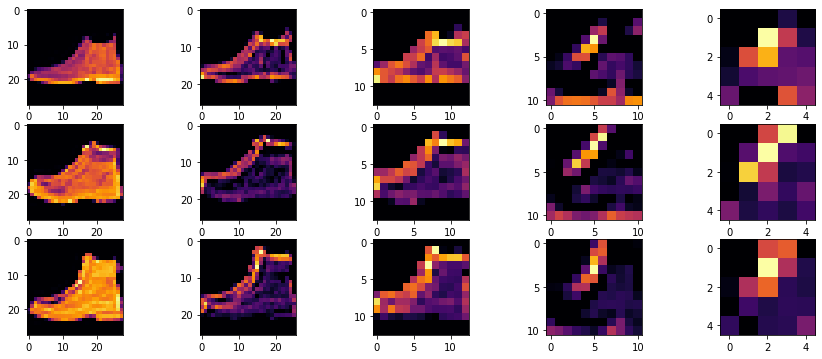

In [148]:
f, axarr = plt.subplots(3,5, figsize=(15, 6))
CANAL=13
CAPAS=[1,2,4,5]

for i, img in enumerate(botines):
    axarr[i,0].imshow(img.squeeze().cpu(), cmap='inferno')
    axarr[i,0].grid(False)

    for i_capa, capa in enumerate(CAPAS):
        activaciones_capa = activaciones[capa]
        feature_map = activaciones_capa[i, CANAL]
        axarr[i, 1+i_capa].imshow(feature_map.cpu(), cmap='inferno')
        axarr[i, 1+i_capa].grid(False)

En la primera convolución podemos ver una detección del borde y la segunda, del empeine de la bota.

## Persistencia de modelos

Es siempre una buena idea **grabar el modelo una vez entrenado**, así se puede volver a usar sin tener que pasar por todo el proceso de entrenamiento, sobretodo teniendo en cuenta que este proceso puede ser bastante largo, y el no determinismo del mismo, que puede finalizar con pesos de modelos diferentes dadas las mismas condiciones iniciales. 
Además, dado que los modelos de redes neuronales son **online**, un modelo previamente entrenado se puede continuer reentrenando cada cierto tiempo, actualizando las relaciones entre inputs y outputs sin tener que empezar desde cero.

Hay varias maneras de persistir modelos. Lo primero que hay que considerar es que se puede persistir los parámetros de manera independiente de la arquitectura de la red, o las dos cosas al mismo tiempo.

### Persistencia de los parámetros de un modelo


Los parámetros aprendidos durante el entrenamiento de un modelo son almacenados en memoria dentre de un diccionario, que se puede acceder a través del método ```state_dict()```, que puede ser persisitido en disco duro con el método ```torch.save()``` y cargado de nuevo sobre un modelo que dispone de la misma arquitectura con el método ```load_state_dict()``` de la clase ```nn.Module```.

In [149]:
print(f'Tamaño del diccionario de parámetros: {len(modelo_fashion.state_dict())}\nLlaves del diccionario {modelo_fashion.state_dict().keys()}')

Tamaño del diccionario de parámetros: 6
Llaves del diccionario odict_keys(['conv.0.weight', 'conv.0.bias', 'conv.3.weight', 'conv.3.bias', 'conv.7.weight', 'conv.7.bias'])


En el caso del modelo de fashionMNIST, vemos que las capas que contienen parámetros entrenables son la 0 (primera capa convolucional), la 3 (segunda capa convolucional) y la 7 (capa lineal de salida). Cada una de ellas tiene un tensor para los pesos y otro para los sesgos.

In [150]:
torch.save(modelo_fashion.state_dict(), 'model_weights.pth')

In [151]:
print(f"Pesos del modelo original entrenado")
print(f"Primer filtro de la primera capa {modelo_fashion.get_parameter('conv.0.weight')[0, 0]}") # primer filtro convolucional de la primera capa convolucional
pred = modelo_fashion(botines)
print(f"Predicciones aleatorias {pred.argmax(1)}")

Pesos del modelo original entrenado
Primer filtro de la primera capa tensor([[ 0.2698, -0.3914, -0.3539],
        [ 0.4247, -0.4083,  0.1113],
        [ 0.4133, -0.3341,  0.3928]], device='cuda:0',
       grad_fn=<SelectBackward0>)
Predicciones aleatorias tensor([9, 9, 9], device='cuda:0')


In [154]:
reset_seed()
modelo_fashion2 = ClassifConv2Layers(in_channels=1, num_classes=10)
modelo_fashion2 = modelo_fashion2.to(DEVICE)
modelo_fashion2.eval()
print(f"Pesos del nuevo modelo sin entrenar")
print(f"Primer filtro de la primera capa {modelo_fashion2.get_parameter('conv.0.weight')[0, 0]}") # primer filtro convolucional de la primera capa convolucional
pred = modelo_fashion2(botines)
print(f"Predicciones aleatorias {pred.argmax(1)}")

Pesos del nuevo modelo sin entrenar
Primer filtro de la primera capa tensor([[ 0.2548,  0.2767, -0.0781],
        [ 0.3062, -0.0730,  0.0673],
        [-0.1623,  0.1958,  0.2938]], device='cuda:0',
       grad_fn=<SelectBackward0>)
Predicciones aleatorias tensor([5, 5, 5], device='cuda:0')


In [155]:
modelo_fashion2.load_state_dict(torch.load('model_weights.pth'))
modelo_fashion2.eval()
print(f"Pesos del nuevo modelo con parámetros entrenados cargados")
print(f"Primer filtro de la primera capa {modelo_fashion2.get_parameter('conv.0.weight')[0, 0]}") # primer filtro convolucional de la primera capa convolucional
pred = modelo_fashion2(botines)
print(f"Predicciones aleatorias {pred.argmax(1)}")

Pesos del nuevo modelo con parámetros entrenados cargados
Primer filtro de la primera capa tensor([[ 0.2698, -0.3914, -0.3539],
        [ 0.4247, -0.4083,  0.1113],
        [ 0.4133, -0.3341,  0.3928]], device='cuda:0',
       grad_fn=<SelectBackward0>)
Predicciones aleatorias tensor([9, 9, 9], device='cuda:0')


Vemos que los pesos cargados son diferentes de los pesos aleatoriamente inicializados.

### Persistencia de paráemtros y arquitectura de modelo


In [175]:
#modelo_fashion.conv[8]._forward_hooks
#del modelo_fashion.conv[7]._forward_hooks[8]

La función ```torch.save()``` también permite persistir el modelo completo, con su arquitectura, lo que implica que no es necesario instanciarlo previamente, cuando se carga con la función ````torch.load()```.

In [176]:
torch.save(modelo_fashion.cpu(), 'modelo_fashion.pth')

In [178]:
modelo_fashion3 = torch.load('modelo_fashion.pth')
modelo_fashion3 = modelo_fashion3.to(DEVICE)
modelo_fashion3.eval()
print(f"Pesos del nuevo modelo con parámetros entrenados cargados")
print(f"Primer filtro de la primera capa {modelo_fashion3.get_parameter('conv.0.weight')[0, 0]}") # primer filtro convolucional de la primera capa convolucional
pred = modelo_fashion3(botines)
print(f"Predicciones aleatorias {pred.argmax(1)}")

Pesos del nuevo modelo con parámetros entrenados cargados
Primer filtro de la primera capa tensor([[ 0.2698, -0.3914, -0.3539],
        [ 0.4247, -0.4083,  0.1113],
        [ 0.4133, -0.3341,  0.3928]], device='cuda:0',
       grad_fn=<SelectBackward0>)
Predicciones aleatorias tensor([9, 9, 9], device='cuda:0')


Ahora que ya sabemos grabar y cargar modelos, es posible modificar la función con el ciclo de entrenamiento, de tal manera que guardemos **checkpoints** del modelo cuando se mejore la pérdida del validation set.

In [2]:
def train_model(modelo, train_dataset, train_batch_size=128, learning_rate = 1e-3, epocas=30, val_split=0, verbose=False):
    """Se encarga de realizar el ciclo de épocas de entrenamiento.

    :modelo:
        instancia creada del modelo a entrenar
    :train_dataset:
        instancia de Dataset con los datos de entrenamiento
    :train_batch_size:
        tamaño del batch size de entrenamiento
    :learning_rate:
        learning rate del optimizador.
    :epocas:
        número de iteraciones de entrenamiento sobre el dataset completo
    :val_split:
        porcentaje del dataset de entrenamiento dedicado a la validación, su valor será limitado al intervalo [0 (sin validación), 0.5]
    :verbose:
        indica si se quiere imprimr el avance del proceso o no
    :returns:
        el modelo entrenado y 4 arrays con los valores de losses y accuracies del training dataset, y los losses y accuracies del val set después de cada época
    """

    reset_seed()

    # Gestión de los loaders de training y validation
    if val_split > 0.5:
        val_split=0.5

    if val_split < 0:
        val_split=0

    if val_split > 0:
        num_training_instances = int(train_dataset.data.shape[0]*(1-val_split))
        num_validation_instances = int(train_dataset.data.shape[0]*val_split)
        print(f"val_split: {val_split}, num_training_instances {num_training_instances}, num_validation_instances {num_validation_instances}")
        training_subset, validation_subset = torch.utils.data.random_split(
            train_dataset, [num_training_instances, num_validation_instances])
    
        train_loader = torch.utils.data.DataLoader(
            training_subset, batch_size=train_batch_size, shuffle=True, num_workers=2)
        validation_loader = torch.utils.data.DataLoader(
            validation_subset, batch_size=1024, num_workers=2)
        
    else : 
        train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=2)


    # Se crea el modelo y optimizador
    modelo = modelo.to(DEVICE) # situar el modelo en el dispositivo de procesamiento
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(modelo.parameters(), lr=learning_rate)

    # Creamos vectores donde almacenaremos los losses y métricas después de cada época
    train_losses = [0] * epocas
    train_accuracies = [0] * epocas
    val_losses = [0] * epocas
    val_accuracies = [0] * epocas

    min_loss = np.Inf

    for epoca in range(epocas):
        epoca_start_time = time.time()
        modelo.train()
        for batch_features, batch_labels in train_loader:
            # Nos aseguramos que los inputs del modelo estén en el mismo dispositivo
            batch_features = batch_features.to(DEVICE)
            batch_labels = batch_labels.to(DEVICE)
            # Generar las predicciones
            batch_preds = modelo(batch_features)
            # Comparar con las realidades a partir del loss function
            loss = loss_fn(batch_preds, batch_labels)
            # Calcular los gradientes de la función de pérdida
            loss.backward()
            # Actualizar parámetros con los gradientes
            optimizer.step()
            # Resetear los gradientes para no reacumularlos
            optimizer.zero_grad()
            # se acumulan los losses de la epoca (ponderados por el tamaño del batch)
            train_losses[epoca] += loss.item() * batch_labels.size(0)
            # se acumulan las predicciones correctas de la epoca
            correctos = (batch_preds.argmax(1) == batch_labels)
            train_accuracies[epoca] += correctos.type(torch.float).sum().item() 

        # se normalizan el loss y el accuracy del training set
        train_losses[epoca] /= len(train_loader.dataset)
        train_accuracies[epoca] /= len(train_loader.dataset)
        
        if val_split > 0:
            # se desactiva la diferenciación automática para la inferencia sobre el val set
            modelo.eval()
            with torch.no_grad():
                for batch_features, batch_labels in validation_loader:
                    # Nos aseguramos que los inputs del modelo estén en el mismo dispositivo
                    batch_features = batch_features.to(DEVICE)
                    batch_labels = batch_labels.to(DEVICE)
                    # Generar las predicciones
                    batch_preds = modelo(batch_features)
                    # Comparar con las realidades a partir del loss function
                    loss = loss_fn(batch_preds, batch_labels)
                    # se acumulan los losses de la epoca (ponderados por el tamaño del batch)
                    val_losses[epoca] += loss.item() * batch_labels.size(0)
                    # se acumulan las predicciones correctas de la epoca
                    correctos = (batch_preds.argmax(1) == batch_labels)
                    val_accuracies[epoca] += correctos.type(torch.float).sum().item() 
            # se normalizan el loss y el accuracy del val set
            val_losses[epoca] /= len(validation_loader.dataset)
            val_accuracies[epoca] /= len(validation_loader.dataset)

        epoca_end_time = time.time()
        segundos = epoca_end_time - epoca_start_time

        if verbose:
            if val_split > 0:
                print(f"{epoca}:  loss: {train_losses[epoca]:>7f}, accuracy: {train_accuracies[epoca]:>7f}, val loss: {val_losses[epoca]:>7f}, val accuracy: {val_accuracies[epoca]:>7f}",
                      f"-- epoch time: {segundos:.2f}")
                
                # model checkpoint
                if val_losses[epoca] < min_loss:
                    torch.save(modelo, "best_model.pth")
                    print(f"Se mejoró el loss de {min_loss} a {val_losses[epoca]}")
                    min_loss = val_losses[epoca]


            else:
                print(f"{epoca}:  loss: {train_losses[epoca]:>7f}, accuracy: {train_accuracies[epoca]:>7f}",
                      f"-- epoch time: {segundos:.2f}")

                # model checkpoint
                if train_losses[epoca] < min_loss:
                    torch.save(modelo, "best_model.pth")
                    print(f"Se mejoró el loss de {min_loss} a {train_losses[epoca]}")
                    min_loss = train_losses[epoca]

    if val_split > 0:     
        return modelo, train_losses, train_accuracies, val_losses, val_accuracies
    else:
        return modelo, train_losses, train_accuracies

In [3]:
modelo_fashion, train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    ClassifConv2Layers(in_channels=1, num_classes=10), fashion_train_dataset,
    train_batch_size=512, learning_rate=1e-3, epocas=30, val_split=0.1, verbose=True)

NameError: name 'ClassifConv2Layers' is not defined